# 基于 TensorFlow 在 SecretFlow 中实现水平联邦目标检测任务

## 引言

本教程基于 TensorFlow 的 [使用 BASNet 进行图像分割教程](https://keras.io/examples/vision/basnet_segmentation/) 而改写，通过本教程，您将了解到现有的基于 TensorFlow 的示例如何快速地迁移到 SecretFlow 隐语的联邦学习框架之下，实现模型的联邦学习化。

## 单机模式

### 小节引言
本小节的代码主要来自于 [Highly accurate boundaries segmentation using BASNet](https://keras.io/examples/vision/basnet_segmentation/) ，主要讲解如何在 Keras 下实现边界感知分割网络（BASNet），通过使用两阶段预测和细化架构，以及混合损失，去预测高精度的边界和图像分割的精细结构。 处于演示效率的考虑，在本次示例，教程通过在数据集 [DUTS-TE](http://saliencydetection.net/duts/) 上使用 140 张图片用来训练和测试，实际上，DUTS是比较大的突出对象分割数据集。 为了教程的简洁，本小节仅仅简要介绍了一下各部分的功能；对于实现的具体解析，请读者移步参考[原教程](https://keras.io/examples/vision/basnet_segmentation/)。

### 下载数据

第一次运行本教程时，将通过下面的单元格下载数据。往后再次运行时，请注释掉下列语句，避免数据的重复下载。

In [1]:
!wget http://saliencydetection.net/duts/download/DUTS-TE.zip
!unzip -q DUTS-TE.zip

--2023-10-22 03:44:18--  http://saliencydetection.net/duts/download/DUTS-TE.zip
Resolving saliencydetection.net (saliencydetection.net)... 36.55.239.177
Connecting to saliencydetection.net (saliencydetection.net)|36.55.239.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139799089 (133M) [application/zip]
Saving to: ‘DUTS-TE.zip’

DUTS-TE.zip         100%[===================>] 133.32M  4.12MB/s    in 30s     

2023-10-22 03:44:49 (4.37 MB/s) - ‘DUTS-TE.zip’ saved [139799089/139799089]



In [2]:
import os

# If you use GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend

2023-10-14 08:02:27.501730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 08:02:27.678637: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-14 08:02:27.683847: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-14 08:02:27.683869: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

### 定义超参数

In [4]:
IMAGE_SIZE = 288
BATCH_SIZE = 4
OUT_CLASSES = 1
TRAIN_SPLIT_RATIO = 0.90
DATA_DIR = "./DUTS-TE/"

### 创建 TensorFlow 数据集

In [5]:
def load_paths(path, split_ratio):
    images = sorted(glob(os.path.join(path, "DUTS-TE-Image/*")))[:140]
    masks = sorted(glob(os.path.join(path, "DUTS-TE-Mask/*")))[:140]

    len_ = int(len(images) * split_ratio)
    return (images[:len_], masks[:len_]), (images[len_:], masks[len_:])


def read_image(path, size, mode):
    x = keras.utils.load_img(path, target_size=size, color_mode=mode)
    x = keras.utils.img_to_array(x)
    x = (x / 255.0).astype(np.float32)
    return x


def preprocess(x_batch, y_batch, img_size, out_classes):
    def f(_x, _y):
        _x, _y = _x.decode(), _y.decode()
        _x = read_image(_x, (img_size, img_size), mode="rgb")  # image
        _y = read_image(_y, (img_size, img_size), mode="grayscale")  # mask
        return _x, _y

    images, masks = tf.numpy_function(f, [x_batch, y_batch], [tf.float32, tf.float32])
    images.set_shape([img_size, img_size, 3])
    masks.set_shape([img_size, img_size, out_classes])
    return images, masks


def load_dataset(image_paths, mask_paths, img_size, out_classes, batch, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        dataset = dataset.cache().shuffle(buffer_size=1000)
    dataset = dataset.map(
        lambda x, y: preprocess(x, y, img_size, out_classes),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_paths, val_paths = load_paths(DATA_DIR, TRAIN_SPLIT_RATIO)

train_dataset = load_dataset(
    train_paths[0], train_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=True
)
val_dataset = load_dataset(
    val_paths[0], val_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=False
)

print(f"Train Dataset: {train_dataset}")
print(f"Validation Dataset: {val_dataset}")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Train Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 288, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None))>
Validation Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 288, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None))>


2023-10-14 08:02:33.958405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-14 08:02:33.958447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: luoyegroup-ubuntu
2023-10-14 08:02:33.958455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: luoyegroup-ubuntu
2023-10-14 08:02:33.958597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.104.5
2023-10-14 08:02:33.958621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.104.5
2023-10-14 08:02:33.958627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.104.5
2023-10-14 08:02:33.958993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is o

### 可视化数据

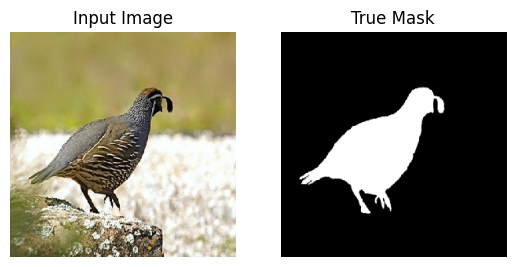

In [6]:
def display(display_list):
    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(keras.utils.array_to_img(display_list[i]), cmap="gray")
        plt.axis("off")
    plt.show()


for image, mask in val_dataset.take(1):
    display([image[0], mask[0]])

### 分析掩码

In [7]:
print(f"Unique values count: {len(np.unique((mask[0] * 255)))}")
print("Unique values:")
print(np.unique((mask[0] * 255)).astype(int))

Unique values count: 245
Unique values:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  61  62  63  65  66  67  68  69  70  71  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 108 109 110 111 112
 113 114 115 116 117 118 119 120 122 123 124 125 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 24

### 构建边界感知分割网络（BASNet）模型

In [8]:
def basic_block(x_input, filters, stride=1, down_sample=None, activation=None):
    """Creates a residual(identity) block with two 3*3 convolutions."""
    residual = x_input

    x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", use_bias=False)(
        x_input
    )
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding="same", use_bias=False)(
        x
    )
    x = layers.BatchNormalization()(x)

    if down_sample is not None:
        residual = down_sample

    x = layers.Add()([x, residual])

    if activation is not None:
        x = layers.Activation(activation)(x)

    return x


def convolution_block(x_input, filters, dilation=1):
    """Apply convolution + batch normalization + relu layer."""
    x = layers.Conv2D(filters, (3, 3), padding="same", dilation_rate=dilation)(x_input)
    x = layers.BatchNormalization()(x)
    return layers.Activation("relu")(x)


def segmentation_head(x_input, out_classes, final_size):
    """Map each decoder stage output to model output classes."""
    x = layers.Conv2D(out_classes, kernel_size=(3, 3), padding="same")(x_input)

    if final_size is not None:
        x = layers.Resizing(final_size[0], final_size[1])(x)

    return x


def get_resnet_block(_resnet, block_num):
    """Extract and return ResNet-34 block."""
    resnet_layers = [3, 4, 6, 3]  # ResNet-34 layer sizes at different block.
    return keras.models.Model(
        inputs=_resnet.get_layer(f"v2_stack_{block_num}_block1_1_conv").input,
        outputs=_resnet.get_layer(
            f"v2_stack_{block_num}_block{resnet_layers[block_num]}_add"
        ).output,
        name=f"resnet34_block{block_num + 1}",
    )

### 预测模块

In [9]:
def basnet_predict(input_shape, out_classes):
    """BASNet Prediction Module, it outputs coarse label map."""
    filters = 64
    num_stages = 6

    x_input = layers.Input(input_shape)

    # -------------Encoder--------------
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x_input)

    resnet = keras_cv.models.ResNet34Backbone(
        include_rescaling=False,
    )

    encoder_blocks = []
    for i in range(num_stages):
        if i < 4:  # First four stages are adopted from ResNet-34 blocks.
            x = get_resnet_block(resnet, i)(x)
            encoder_blocks.append(x)
            x = layers.Activation("relu")(x)
        else:  # Last 2 stages consist of three basic resnet blocks.
            x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
            x = basic_block(x, filters=filters * 8, activation="relu")
            x = basic_block(x, filters=filters * 8, activation="relu")
            x = basic_block(x, filters=filters * 8, activation="relu")
            encoder_blocks.append(x)

    # -------------Bridge-------------
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    encoder_blocks.append(x)

    # -------------Decoder-------------
    decoder_blocks = []
    for i in reversed(range(num_stages)):
        if i != (num_stages - 1):  # Except first, scale other decoder stages.
            shape = keras.backend.int_shape(x)
            x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)

        x = layers.concatenate([encoder_blocks[i], x], axis=-1)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        decoder_blocks.append(x)

    decoder_blocks.reverse()  # Change order from last to first decoder stage.
    decoder_blocks.append(encoder_blocks[-1])  # Copy bridge to decoder.

    # -------------Side Outputs--------------
    decoder_blocks = [
        segmentation_head(decoder_block, out_classes, input_shape[:2])
        for decoder_block in decoder_blocks
    ]

    return keras.models.Model(inputs=[x_input], outputs=decoder_blocks)

### 残差修正模块

In [10]:
def basnet_rrm(base_model, out_classes):
    """BASNet Residual Refinement Module(RRM) module, output fine label map."""
    num_stages = 4
    filters = 64

    x_input = base_model.output[0]

    # -------------Encoder--------------
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x_input)

    encoder_blocks = []
    for _ in range(num_stages):
        x = convolution_block(x, filters=filters)
        encoder_blocks.append(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    # -------------Bridge--------------
    x = convolution_block(x, filters=filters)

    # -------------Decoder--------------
    for i in reversed(range(num_stages)):
        shape = keras.backend.int_shape(x)
        x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)
        x = layers.concatenate([encoder_blocks[i], x], axis=-1)
        x = convolution_block(x, filters=filters)

    x = segmentation_head(x, out_classes, None)  # Segmentation head.

    # ------------- refined = coarse + residual
    x = layers.Add()([x_input, x])  # Add prediction + refinement output

    return keras.models.Model(inputs=[base_model.input], outputs=[x])

### 组合预测模块和修正模块

In [11]:
def basnet(input_shape, out_classes):
    """BASNet, it's a combination of two modules
    Prediction Module and Residual Refinement Module(RRM)."""

    # Prediction model.
    predict_model = basnet_predict(input_shape, out_classes)
    # Refinement model.
    refine_model = basnet_rrm(predict_model, out_classes)

    output = [refine_model.output]  # Combine outputs.
    output.extend(predict_model.output)

    output = [layers.Activation("sigmoid")(_) for _ in output]  # Activations.

    return keras.models.Model(inputs=[predict_model.input], outputs=output)

### 混合损失

In [12]:
class BasnetLoss(keras.losses.Loss):
    """BASNet hybrid loss."""

    def __init__(self, **kwargs):
        super().__init__(name="basnet_loss", **kwargs)
        self.smooth = 1.0e-9

        # Binary Cross Entropy loss.
        self.cross_entropy_loss = keras.losses.BinaryCrossentropy()
        # Structural Similarity Index value.
        self.ssim_value = tf.image.ssim
        #  Jaccard / IoU loss.
        self.iou_value = self.calculate_iou

    def calculate_iou(
        self,
        y_true,
        y_pred,
    ):
        """Calculate intersection over union (IoU) between images."""
        intersection = backend.sum(backend.abs(y_true * y_pred), axis=[1, 2, 3])
        union = backend.sum(y_true, [1, 2, 3]) + backend.sum(y_pred, [1, 2, 3])
        union = union - intersection
        return backend.mean(
            (intersection + self.smooth) / (union + self.smooth), axis=0
        )

    def call(self, y_true, y_pred):
        cross_entropy_loss = self.cross_entropy_loss(y_true, y_pred)

        ssim_value = self.ssim_value(y_true, y_pred, max_val=1)
        ssim_loss = backend.mean(1 - ssim_value + self.smooth, axis=0)

        iou_value = self.iou_value(y_true, y_pred)
        iou_loss = 1 - iou_value

        # Add all three losses.
        return cross_entropy_loss + ssim_loss + iou_loss


basnet_model = basnet(
    input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3], out_classes=OUT_CLASSES
)  # Create model.
basnet_model.summary()  # Show model summary.

optimizer = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8)
# Compile model.
basnet_model.compile(
    loss=BasnetLoss(),
    optimizer=optimizer,
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")],
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 288, 288, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 resnet34_block1 (Functional)   (None, None, None,   222720      ['conv2d[0][0]']                 
                                64)                                                         

#### 训练模型

In [13]:
basnet_model.fit(train_dataset, validation_data=val_dataset, epochs=1)

32/32 [==============================] - 1405s 43s/step - loss: 16.0968 - activation_46_loss: 1.9875 - activation_47_loss: 2.0213 - activation_48_loss: 2.0424 - activation_49_loss: 2.1157 - activation_50_loss: 2.0821 - activation_51_loss: 1.9536 - activation_52_loss: 1.9281 - activation_53_loss: 1.9660 - activation_46_mae: 0.2455 - activation_47_mae: 0.2579 - activation_48_mae: 0.2762 - activation_49_mae: 0.2982 - activation_50_mae: 0.2919 - activation_51_mae: 0.2488 - activation_52_mae: 0.2316 - activation_53_mae: 0.2272 - val_loss: 28.6270 - val_activation_46_loss: 6.6966 - val_activation_47_loss: 7.8865 - val_activation_48_loss: 2.6089 - val_activation_49_loss: 2.3249 - val_activation_50_loss: 2.3181 - val_activation_51_loss: 2.3536 - val_activation_52_loss: 2.2359 - val_activation_53_loss: 2.2025 - val_activation_46_mae: 0.7320 - val_activation_47_mae: 0.7401 - val_activation_48_mae: 0.5185 - val_activation_49_mae: 0.2412 - val_activation_50_mae: 0.2624 - val_activation_51_mae: 0.2

#### 可视化预测
基于训练成本过高的原因，在教程里，我们不完全训练 BASNet，所以我们将通过下载[此处](https://github.com/hamidriasat/BASNet/tree/basnet_keras)已经训练好的模型权重放在当前文件夹之下 **（./）** 进行预测效果的演示。

您既可以通过手动下载模型权重，然后放置到对应的文件夹，也可以通过运行下方单元格下载模型权重。

In [14]:
# !!gdown 1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg

In [15]:
def normalize_output(prediction):
    max_value = np.max(prediction)
    min_value = np.min(prediction)
    return (prediction - min_value) / (max_value - min_value)


# Load weights.
basnet_model.load_weights("./basnet_weights.h5")

#### 预测

1/1 [==============================] - 18s 18s/step


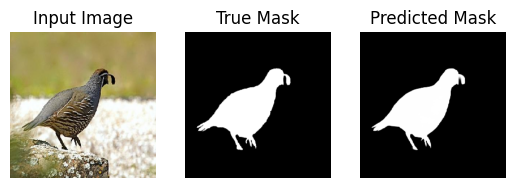

In [16]:
for image, mask in val_dataset.take(1):
    pred_mask = basnet_model.predict(image)
    display([image[0], mask[0], normalize_output(pred_mask[0][0])])

## 联邦学习模式

### 小节引言
通过单机模式，我们已经学会到，如何在单机模式下使用 BASNet 实现图像分割，本小节我们将看到如何将单机模型如何快速和低成本地迁移到 SecretFlow 隐语的联邦学习框架之下。

In [17]:
%load_ext autoreload
%autoreload 2

### 隐语环境初始化

In [18]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()
sf.init(['alice', 'bob', 'charlie'], address="local", log_to_driver=False)
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.2.0.dev20231009


2023-10-14 08:26:29,626	INFO worker.py:1538 -- Started a local Ray instance.


### 进行数据划分

首先为了模拟联邦学习多方参与的场景设定，我们先人为进行一下数据集划分。为方便演示，我们对数据按参与方进行均匀划分

我们假定联邦学习的数据拥有方是 **alice** 和 **bob**

In [2]:
import os
import shutil

from os.path import join

dataset_path = './data'
partys = ['alice', 'bob']

for p in partys:
    party_images_path = join(dataset_path, p, 'DUTS-TE-Image')
    party_masks_path = join(dataset_path, p, 'DUTS-TE-Mask')

    os.makedirs(party_images_path, exist_ok=True)
    os.makedirs(party_masks_path, exist_ok=True)

我们可以看到，图像分割的训练数据集主要由两部分组成：图片（image）和对应的标注（mask），分别位于 **"./DUTS-TE/DUTS-TE-Image"** 和 **"./DUTS-TE/DUTS-TE-Mask"** ；我们的参与方数据文件夹分别为 **"./data/alice/"** 和 **"./data/bob/"**；所以我们分别在参与方数据文件夹下建立 **'DUTS-TE-Image'** 和 **'DUTS-TE-Mask'** 来保存对应的数据。

In [20]:
images_path = join(DATA_DIR, 'DUTS-TE-Image')
masks_path = join(DATA_DIR, 'DUTS-TE-Mask')

In [ ]:
index = 0
partys_len = len(partys)

for image_name in sorted(os.listdir(images_path)):
    name, ext = os.path.splitext(image_name)

    image_path = join(images_path, image_name)
    mask_path = join(masks_path, name + '.png')

    if (not os.path.exists(image_path)) or (not os.path.exists(mask_path)):
        continue

    party_id = index % partys_len

    target_images_path = join(dataset_path, partys[party_id], 'DUTS-TE-Image')
    target_masks_path = join(dataset_path, partys[party_id], 'DUTS-TE-Mask')

    shutil.copy(image_path, target_images_path)
    # if you want to watch the process of copying the image to each party, uncomment the following line
    # print(f'{index}: copy {image_path}-->{target_images_path}')

    shutil.copy(mask_path, target_masks_path)
    # if you want to watch the process of copying the image to each party, uncomment the following line
    # print(f'{index}: copy {mask_path}-->{target_masks_path}')

    index += 1

### 封装 DataBuilder

在迁移过程，对于数据集的预处理方式，联邦学习模式和单机模式是一样的，我们不再重复。为了完成迁移适配过程，我们只需要参考[在 SecretFlow 中使用自定义 DataBuilder（TensorFlow）](https://github.com/secretflow/secretflow/blob/main/docs/tutorial/CustomDataLoaderTF.ipynb) 封装我们自定义 DataBuilder 即可。现在，参考原教程，我们封装对应的DataBuilder，所以我们也不需要额外写很多代码。

In [22]:
def create_dataset_builder(
    batch_size=32,
):
    def dataset_builder(folder_path, stage="train"):
        import math

        TRAIN_SPLIT_RATIO = 0.90

        train_paths, val_paths = load_paths(folder_path, TRAIN_SPLIT_RATIO)

        train_dataset = load_dataset(
            train_paths[0],
            train_paths[1],
            IMAGE_SIZE,
            OUT_CLASSES,
            BATCH_SIZE,
            shuffle=True,
        )
        eval_dataset = load_dataset(
            val_paths[0],
            val_paths[1],
            IMAGE_SIZE,
            OUT_CLASSES,
            BATCH_SIZE,
            shuffle=False,
        )

        if stage == "train":
            train_step_per_epoch = len(train_dataset)
            return train_dataset, train_step_per_epoch
        elif stage == "eval":
            eval_step_per_epoch = len(eval_dataset)
            return eval_dataset, eval_step_per_epoch

    return dataset_builder

### 构建 dataset_builder_dict

In [23]:
data_builder_dict = {
    alice: create_dataset_builder(
        batch_size=32,
    ),
    bob: create_dataset_builder(
        batch_size=32,
    ),
}

### 定义网络结构

得益于隐语优异的设计，我们只需要将单机模式下定义的网络结构，进行适当的封装即可，并且可以复用单机模式下定义的大量函数和模块，所以我们只需要少量的代码就可以完成这个过程。

In [24]:
def create_fl_basnet_model(input_shape, out_classes, name='basnet_model'):
    def create_model():
        from tensorflow import keras

        # Create model
        basnet_model = basnet(input_shape=input_shape, out_classes=out_classes)
        # Compile model
        optimizer = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8)
        basnet_model.compile(
            loss=BasnetLoss(),
            optimizer=optimizer,
            metrics=[keras.metrics.MeanAbsoluteError(name="mae")],
        )
        return basnet_model

    return create_model

In [25]:
from secretflow.ml.nn import FLModel
from secretflow.security.aggregation import SecureAggregator

### 定义TensorFlow 后端的 FLModel 

In [26]:
device_list = [alice, bob]
aggregator = SecureAggregator(charlie, [alice, bob])

# prepare model
input_shape = [IMAGE_SIZE, IMAGE_SIZE, 3]
out_classes = OUT_CLASSES

# keras model
model = create_fl_basnet_model(input_shape, out_classes, name='basnet_model')


fed_model = FLModel(
    device_list=device_list,
    model=model,
    aggregator=aggregator,
    backend="tensorflow",
    strategy="fed_avg_w",
    random_seed=2022,
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


### 给出参与方数据集路径

In [27]:
data = {
    alice: join(dataset_path, partys[0]),
    bob: join(dataset_path, partys[1]),
}

### 开始训练模型
同样出于演示的目的，我们只简单训练几个 epochs

In [28]:
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=5,
    batch_size=32,
    aggregate_freq=1,
    sampler_method="batch",
    random_seed=2022,
    dp_spent_step_freq=1,
    dataset_builder=data_builder_dict,
)

INFO:root:FL Train Params: {'x': {PYURuntime(alice): './data/alice', PYURuntime(bob): './data/bob'}, 'y': None, 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': {PYURuntime(alice): './data/alice', PYURuntime(bob): './data/bob'}, 'shuffle': False, 'class_weight': None, 'sample_weight': None, 'validation_freq': 1, 'aggregate_freq': 1, 'label_decoder': None, 'max_batch_size': 20000, 'prefetch_buffer_size': None, 'sampler_method': 'batch', 'random_seed': 2022, 'dp_spent_step_freq': 1, 'audit_log_dir': None, 'dataset_builder': {PYURuntime(alice): <function create_dataset_builder.<locals>.dataset_builder at 0x7fd260f58d30>, PYURuntime(bob): <function create_dataset_builder.<locals>.dataset_builder at 0x7fd260f58ee0>}, 'wait_steps': 100, 'self': <secretflow.ml.nn.fl.fl_model.FLModel object at 0x7fd53daf0610>}
100%|██████████| 32/32 [44:55<00:00, 84.25s/it, epoch: 5/5 -  loss:11.421000480651855  activation_46_loss:1.435970902442932

### 可视化训练历史

In [29]:
history.global_history.keys()

dict_keys(['loss', 'activation_46_loss', 'activation_47_loss', 'activation_48_loss', 'activation_49_loss', 'activation_50_loss', 'activation_51_loss', 'activation_52_loss', 'activation_53_loss', 'activation_46_mae', 'activation_47_mae', 'activation_48_mae', 'activation_49_mae', 'activation_50_mae', 'activation_51_mae', 'activation_52_mae', 'activation_53_mae', 'val_loss', 'val_activation_46_loss', 'val_activation_47_loss', 'val_activation_48_loss', 'val_activation_49_loss', 'val_activation_50_loss', 'val_activation_51_loss', 'val_activation_52_loss', 'val_activation_53_loss', 'val_activation_46_mae', 'val_activation_47_mae', 'val_activation_48_mae', 'val_activation_49_mae', 'val_activation_50_mae', 'val_activation_51_mae', 'val_activation_52_mae', 'val_activation_53_mae'])

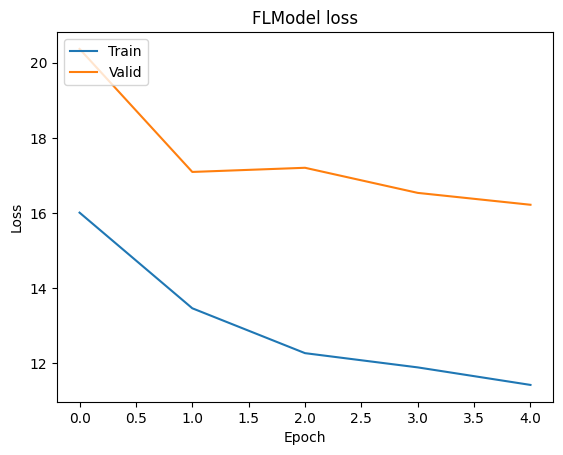

In [30]:
from matplotlib import pyplot as plt

# Draw loss values for training & validation
plt.plot(history.global_history['loss'])
plt.plot(history.global_history['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

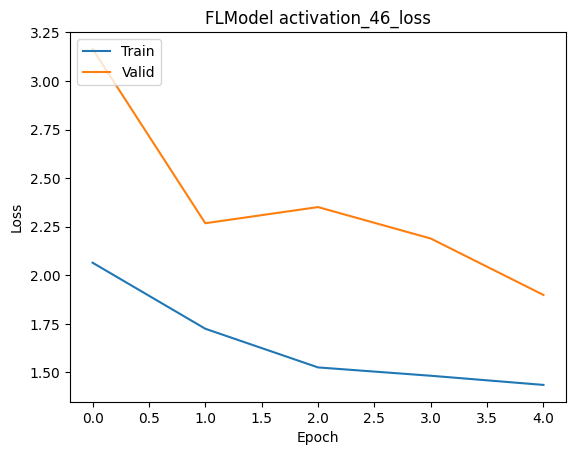

In [31]:
# Draw loss values for training & validation
plt.plot(history.global_history['activation_46_loss'])
plt.plot(history.global_history['val_activation_46_loss'])
plt.title('FLModel activation_46_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

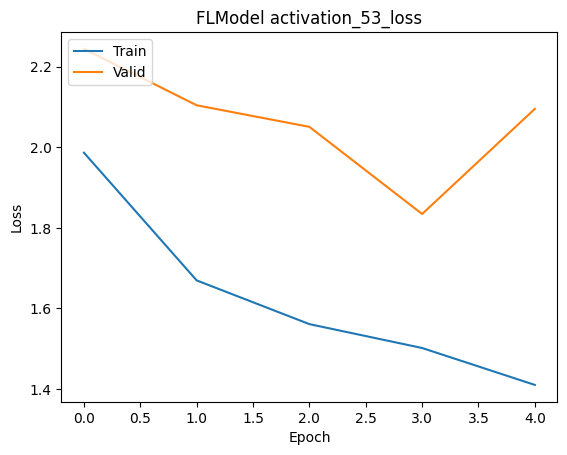

In [32]:
# Draw loss values for training & validation
plt.plot(history.global_history['activation_53_loss'])
plt.plot(history.global_history['val_activation_53_loss'])
plt.title('FLModel activation_53_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

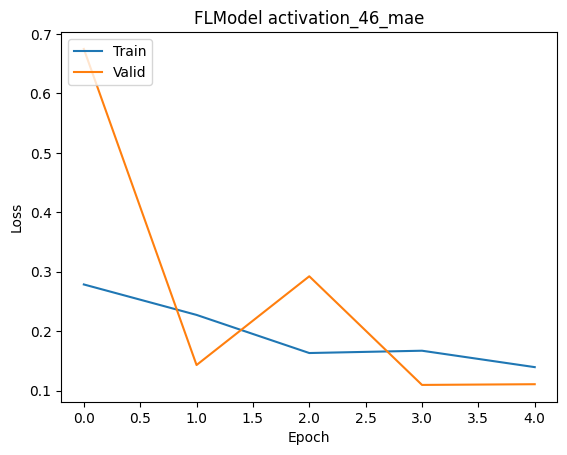

In [33]:
# Draw loss values for training & validation
plt.plot(history.global_history['activation_46_mae'])
plt.plot(history.global_history['val_activation_46_mae'])
plt.title('FLModel activation_46_mae')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

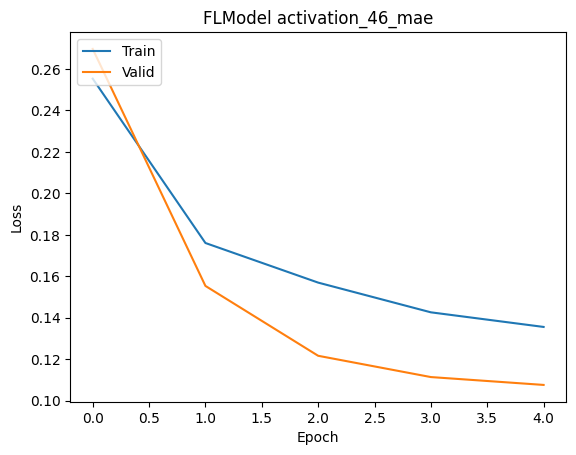

In [34]:
# Draw loss values for training & validation
plt.plot(history.global_history['activation_53_mae'])
plt.plot(history.global_history['val_activation_53_mae'])
plt.title('FLModel activation_46_mae')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()